<a href="https://colab.research.google.com/github/karthik1636/karthik.github.io/blob/main/Transformer_Emotion_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Loading and Preparing the Dataset**

In [8]:
!nvidia-smi

Sat Apr 13 21:09:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              49W / 400W |    591MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Loading the dataset
data = pd.read_csv('emotion_sentimen_dataset.csv')

# Displaying the first few rows of the dataframe
print(data.head())

# Preprocessing the text

# Encodeing the labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Emotion'])

# Preparing text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
maxlen = 178  # seting this to the max length that is found

# Padding
X = pad_sequences(sequences, maxlen=maxlen)

# Labels
y = data['label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


   Unnamed: 0                                               text  Emotion
0           0  i seriously hate one subject to death but now ...     hate
1           1                 im so full of life i feel appalled  neutral
2           2  i sit here to write i start to dig out my feel...  neutral
3           3  ive been really angry with r and i feel like a...    anger
4           4  i feel suspicious if there is no one outside l...  neutral


**Step 2: Defining the Transformer Model**

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Parameters
vocab_size = 10000  # as used in the tokenizer
embed_dim = 32  # embedding dimension
num_heads = 2  # number of attention heads
ff_dim = 64  # hidden layer size in feed forward network inside transformer

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

model = Sequential([
    TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim),
    TransformerBlock(embed_dim, num_heads, ff_dim),
    GlobalAveragePooling1D(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


**Step 3: Training the Model**

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
20989/20989 [==============================] - 178s 8ms/step - loss: 0.0641 - accuracy: 0.9892 - val_loss: 0.0263 - val_accuracy: 0.9967
Epoch 2/10
20989/20989 [==============================] - 156s 7ms/step - loss: 0.0259 - accuracy: 0.9967 - val_loss: 0.0246 - val_accuracy: 0.9969
Epoch 3/10
20989/20989 [==============================] - 156s 7ms/step - loss: 0.0223 - accuracy: 0.9970 - val_loss: 0.0233 - val_accuracy: 0.9969
Epoch 4/10
20989/20989 [==============================] - 156s 7ms/step - loss: 0.0194 - accuracy: 0.9972 - val_loss: 0.0223 - val_accuracy: 0.9973
Epoch 5/10
20989/20989 [==============================] - 155s 7ms/step - loss: 0.0176 - accuracy: 0.9973 - val_loss: 0.0209 - val_accuracy: 0.9972
Epoch 6/10
20989/20989 [==============================] - 155s 7ms/step - loss: 0.0158 - accuracy: 0.9975 - val_loss: 0.0212 - val_accuracy: 0.9974
Epoch 7/10
20989/20989 [==============================] - 155s 7ms/step - loss: 0.0142 - accuracy: 0.9976 - val_

**Step 4: Evaluating the Model**

In [6]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%, Test loss: {test_loss:.2f}")


528/528 - 1s - loss: 0.0501 - accuracy: 0.9960 - 1s/epoch - 2ms/step
Test accuracy: 99.60%, Test loss: 0.05


Plotting the Results

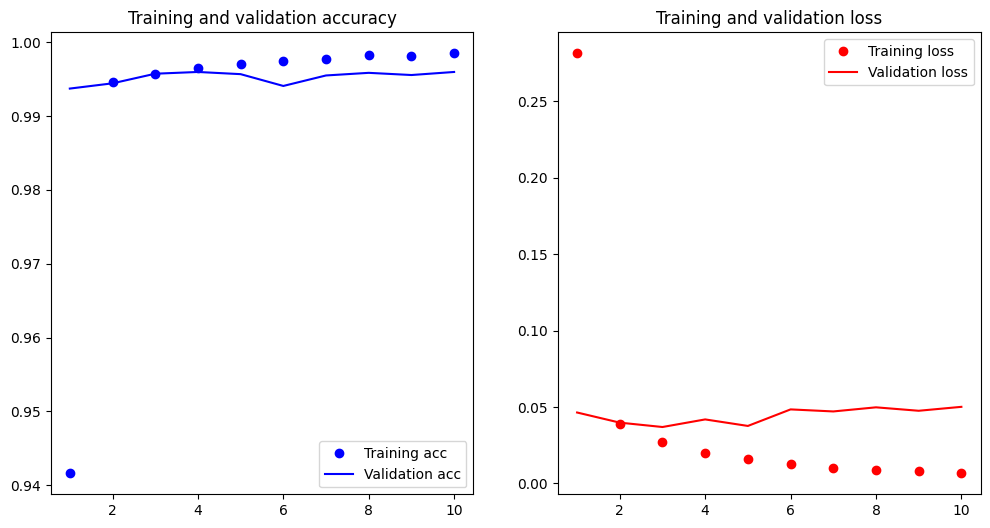

In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting the accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plotting the loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Calling the function with the history from the model training
plot_history(history)
